## Delta[HHB2] Fitting

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import sys
! pip install pmcx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 96.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)

Mounted at /content/drive


In [3]:
from FD_msNIRS_2layers import extract_freq as ef

### Read Simulation data

In [4]:
import os
import pickle
import numpy as np

In [5]:
result_folder = '/content/drive/MyDrive/MCX_data/result_folder/'

In [6]:
def row_construct(dictt):
    re = np.zeros((1, 96))
    col = 0
    for k, v in dictt.items():  # four distances
        TPSF_list = v
        uac_i, udc_i, p1 = ef(110e6, TPSF_list, tend=1e-08, devf=1000)  # 8 wavelengths
        combined = []
        for i in range(8):
            combined.extend([uac_i[i], udc_i[i], p1[i]])  # Interleave the values
        re[0, col:col+24] = combined  # Each set contributes 24 values
        col += 24
    return re

In [7]:
def load_and_process_all(result_folder):
    # List all .pkl files
    files = [f for f in os.listdir(result_folder) if f.endswith('.pkl')]

    # Extract IDs and sort by ID
    sorted_ids = sorted([int(f.replace('.pkl', '')) for f in files])
    sorted_files = [f"{i}.pkl" for i in sorted_ids]

    # Initialize result list
    all_rows = []

    for file in sorted_files:
        file_path = os.path.join(result_folder, file)

        # Load dictionary
        with open(file_path, 'rb') as f:
            dictt = pickle.load(f)

        # Apply row_construct to get a (1, 96) array
        row = row_construct(dictt)
        all_rows.append(row)

    # Stack into a (n_files, 96) array
    result_array = np.vstack(all_rows)
    return result_array, sorted_ids

In [8]:
final_array, sorted_ids = load_and_process_all(result_folder)

In [9]:
# Save to CSV
output_csv_path = '/content/drive/MyDrive/MCX_data/processed_results.csv'
pd.DataFrame(final_array).to_csv(output_csv_path, index=False, header=False)

In [19]:
final_array.shape

(120, 96)

### GT

In [20]:
GT_folder = '/content/drive/MyDrive/MCX_data/csv'

In [21]:
csv_files = glob.glob(os.path.join(GT_folder, '*.csv'))
GT_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [22]:
GT_all.head()

,HBO1,HHB1,HBO2,HHB2,d1,a1,a2,b1,b2,ID
0,10.618102,12.007143,46.959818,26.97317,12.0,1.889986,1.174251,1.233088,0.841004,1
1,18.118102,7.007143,31.959818,16.97317,17.0,3.139986,2.674251,0.983088,0.391004,2
2,6.868102,4.507143,39.459818,31.97317,19.0,2.514986,3.424251,0.858088,1.066004,3
3,14.368102,9.507143,54.459818,21.97317,14.0,3.764986,1.924251,1.108088,0.616004,4
4,16.243102,5.757143,35.709818,29.47317,10.0,1.577486,1.549251,1.045588,0.953504,5


In [23]:
# Ensure ID column is integer
GT_all['ID'] = GT_all['ID'].astype(int)

# Filter and sort GT_all to match the sorted_ids order
GT_filtered = GT_all[GT_all['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()

# Extract HHB2 as Y
Y = GT_filtered['HHB2'].values  # numpy array (n_samples,)
Y = Y.reshape(-1, 1)

In [24]:
Y.shape

(120, 1)

In [25]:
X = final_array

In [26]:
X.shape

(120, 96)

In [27]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale X
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Scale Y
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

### Create Data Pair: [X1 , X2] = Y1 - Y2

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Step 2: Pairing function
def generate_pairs(X1, Y1, X2=None, Y2=None):
    X_pairs = []
    Y_diffs = []

    if X2 is None:
        # Pair within the same set (X1 vs X1)
        for i in range(len(X1)):
            for j in range(len(X1)):
                x_pair = np.concatenate([X1[i], X1[j]])
                y_diff = Y1[i, 0] - Y1[j, 0]
                X_pairs.append(x_pair)
                Y_diffs.append(y_diff)
    else:
        # Pair across different sets (X1 vs X2)
        for i in range(len(X1)):
            for j in range(len(X2)):
                x_pair = np.concatenate([X1[i], X2[j]])
                y_diff = Y1[i, 0] - Y2[j, 0]
                X_pairs.append(x_pair)
                Y_diffs.append(y_diff)

    return np.array(X_pairs), np.array(Y_diffs).reshape(-1, 1)

# Step 3: Generate all combinations
X_train_pairs, Y_train_diffs = generate_pairs(X_train, Y_train)                    # train vs train
X_test_pairs, Y_test_diffs = generate_pairs(X_test, Y_test)                        # test vs test
X_cross_pairs, Y_cross_diffs = generate_pairs(X_train, Y_train, X_test, Y_test)    # train vs test

# Step 4: Print results
print("Train pairs:", X_train_pairs.shape, Y_train_diffs.shape)  # (144*144, 192)
print("Test pairs:", X_test_pairs.shape, Y_test_diffs.shape)     # (16*16, 192)
##print("Cross pairs:", X_cross_pairs.shape, Y_cross_diffs.shape)

Train pairs: (11664, 192) (11664, 1)
Test pairs: (144, 192) (144, 1)


### XGboost

In [29]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler


model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    max_depth=16,
    learning_rate=0.01,
    tree_method='gpu_hist',  # Enable GPU acceleration
    predictor='gpu_predictor'
)

#model.fit(X_train_pairs, Y_train_diffs)

model.fit(X_train_pairs, Y_train_diffs)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

In [30]:
y_preds = np.column_stack([model.predict(X_test_pairs)])
mse = np.mean((y_preds - Y_test_diffs)**2, axis=0)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [31]:
mse

array([1.05221244])

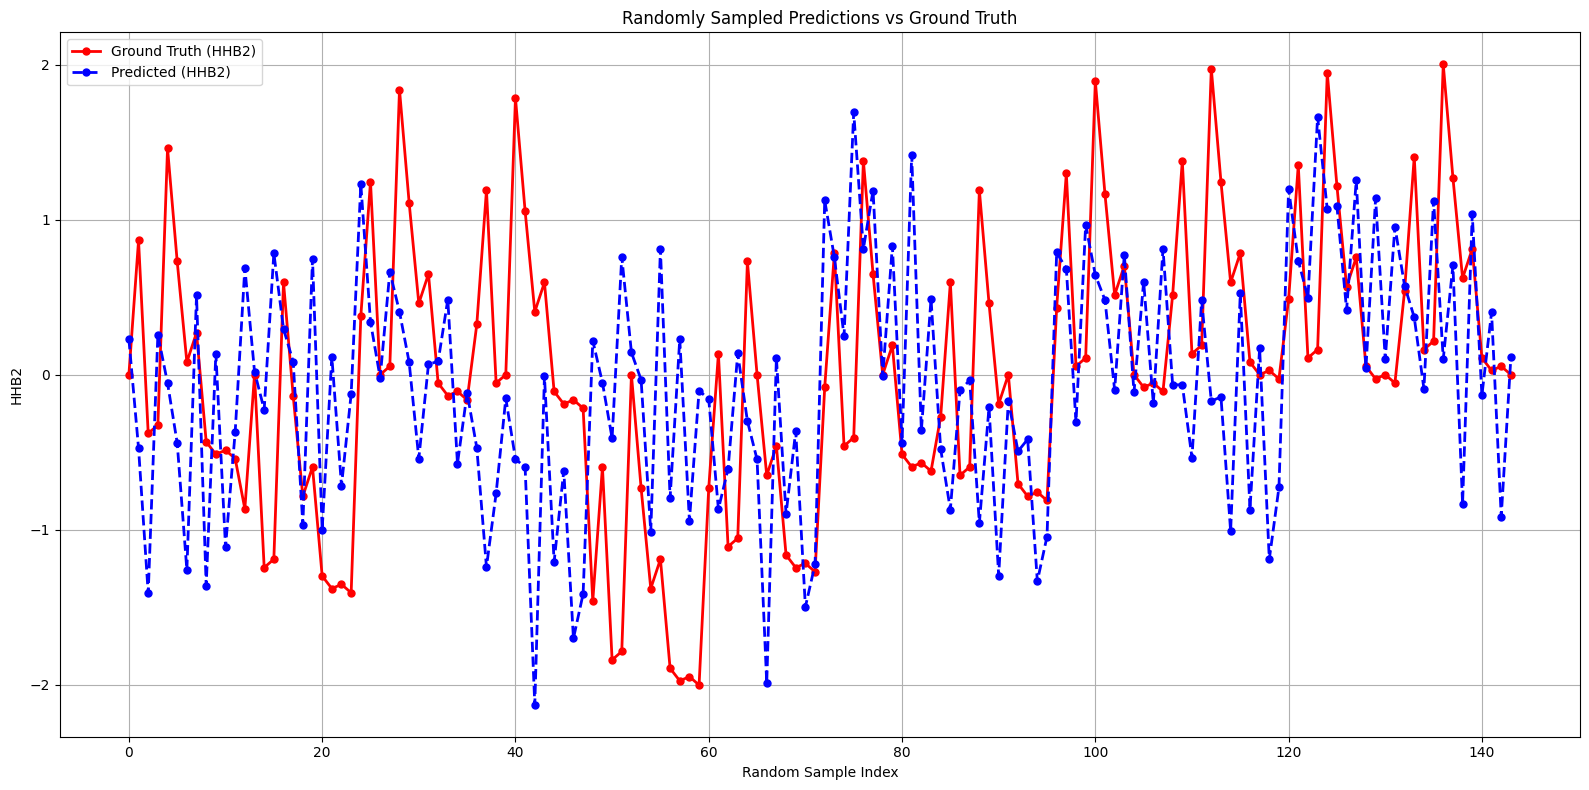

In [32]:
# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(Y_test_diffs, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_preds, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

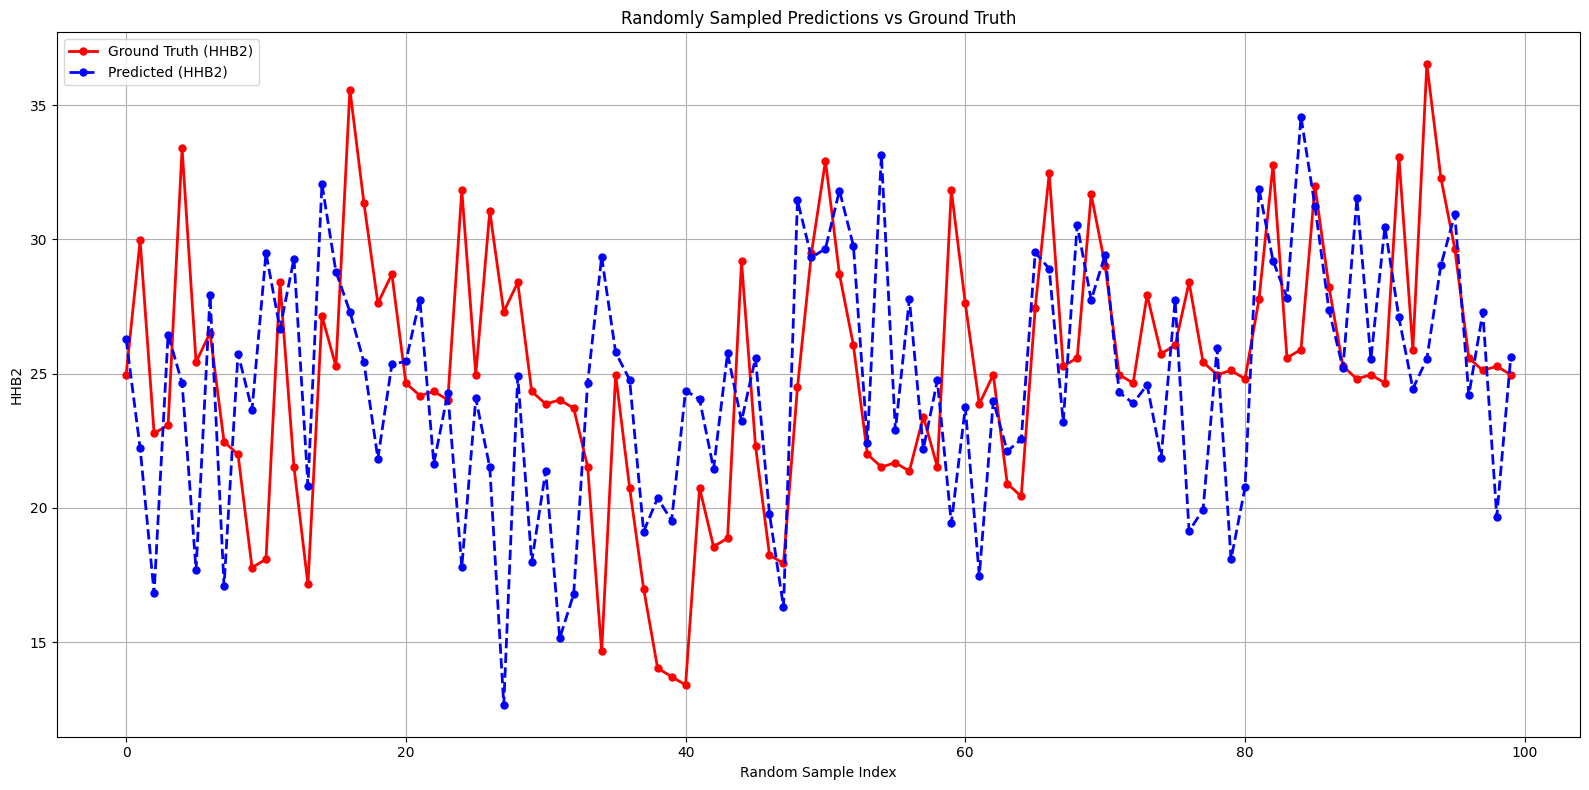

In [33]:
# Randomly select 100 indices
indices = np.random.choice(len(Y_test_diffs), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_preds.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test_diffs.reshape(-1, 1)).flatten()

# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE (original scale): 35.0527


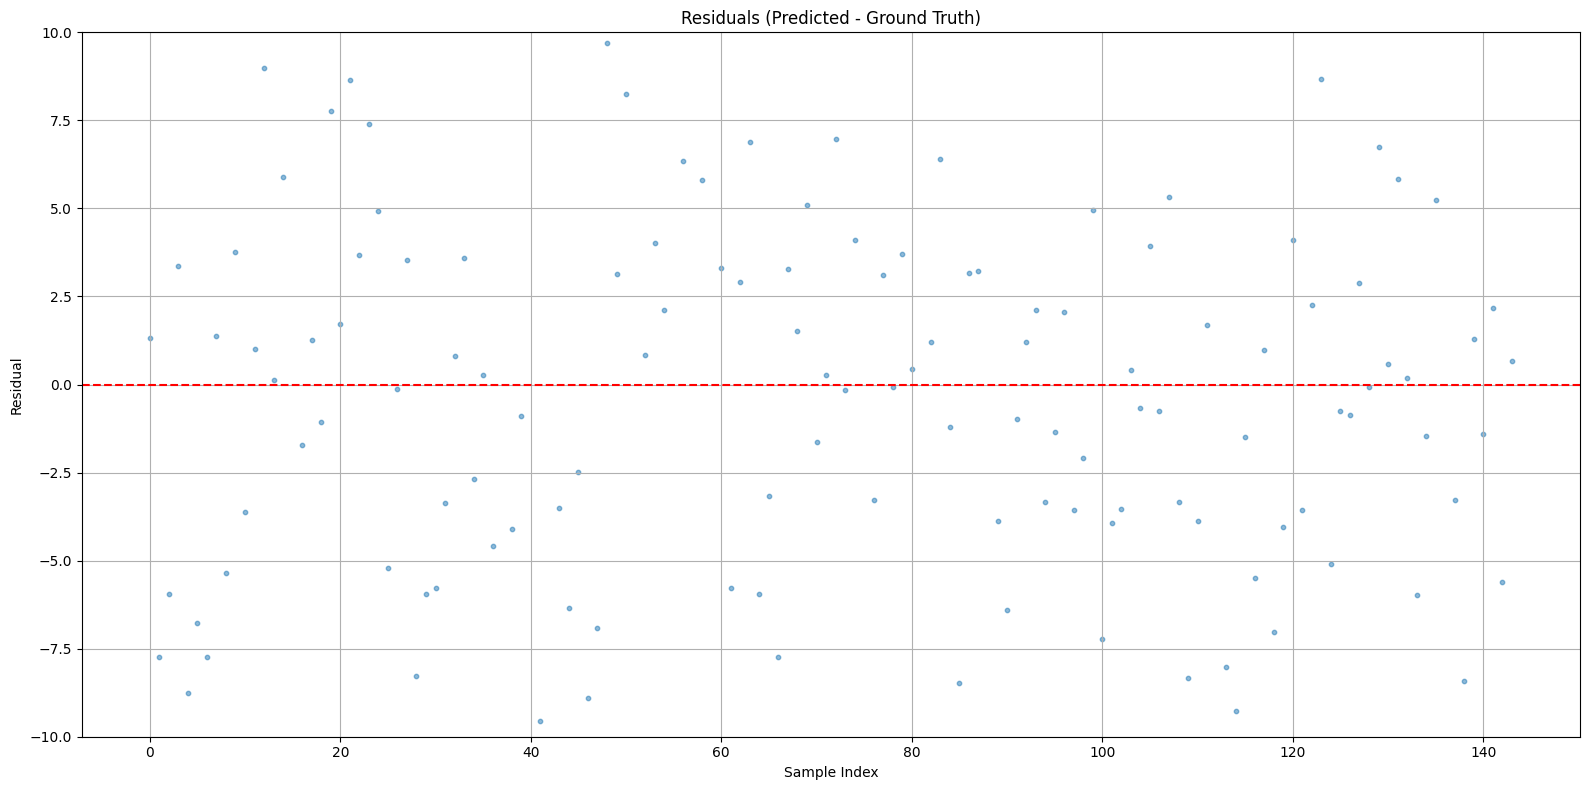

In [34]:
# Inverse-transform predictions and ground truth
y_pred_orig = scaler_y.inverse_transform(y_preds)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(Y_test_diffs)     # shape (n, 1)

# Compute residuals in original scale
residuals = y_pred_orig - y_test_orig

mse_rescaled = mean_squared_error(y_test_orig, y_pred_orig)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.ylim(-10, 10)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
X_train_pairs.shape

(11664, 192)

### ANN

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout


model = Sequential([
    Input(shape=(192,)),
    Dense(192, activation='relu'),
    Dropout(0.2),

    Dense(2048, activation='relu'),
    Dropout(0.3),

    Dense(4096, activation='relu'),
    Dropout(0.3),

    Dense(8192, activation='relu'),
    Dropout(0.3),

    Dense(4096, activation='relu'),
    Dropout(0.3),

    Dense(2048, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(512, activation='relu'),
    Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.1),

    Dense(1)  # Output layer for regression
])


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1.5e-5)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train_pairs, Y_train_diffs, epochs=150, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - loss: 2.1723 - val_loss: 2.0098
Epoch 2/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1416 - val_loss: 2.0193
Epoch 3/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1362 - val_loss: 2.0661
Epoch 4/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1092 - val_loss: 2.0600
Epoch 5/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0955 - val_loss: 2.0918
Epoch 6/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1063 - val_loss: 2.0916
Epoch 7/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0578 - val_loss: 2.2350
Epoch 8/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.9679 - val_loss: 2.2299
Epoch 9/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.9078 - val_loss: 2.2578
Epoch 10/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8949 - val_loss: 2.3255
Epoch 11/150
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8452 - val_loss: 2.3113
Epoch 12/150
292/292 ━━━━━━━━━━━━━━━━━

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 192, but received input with shape (32, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 1), dtype=float32)
  • training=False
  • mask=None

In [38]:
# Predict and evaluate
y_pred = model.predict(X_test_pairs)
mse = mean_squared_error(Y_test_diffs, y_pred)
print(f"Test MSE: {mse:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Test MSE: 0.9316


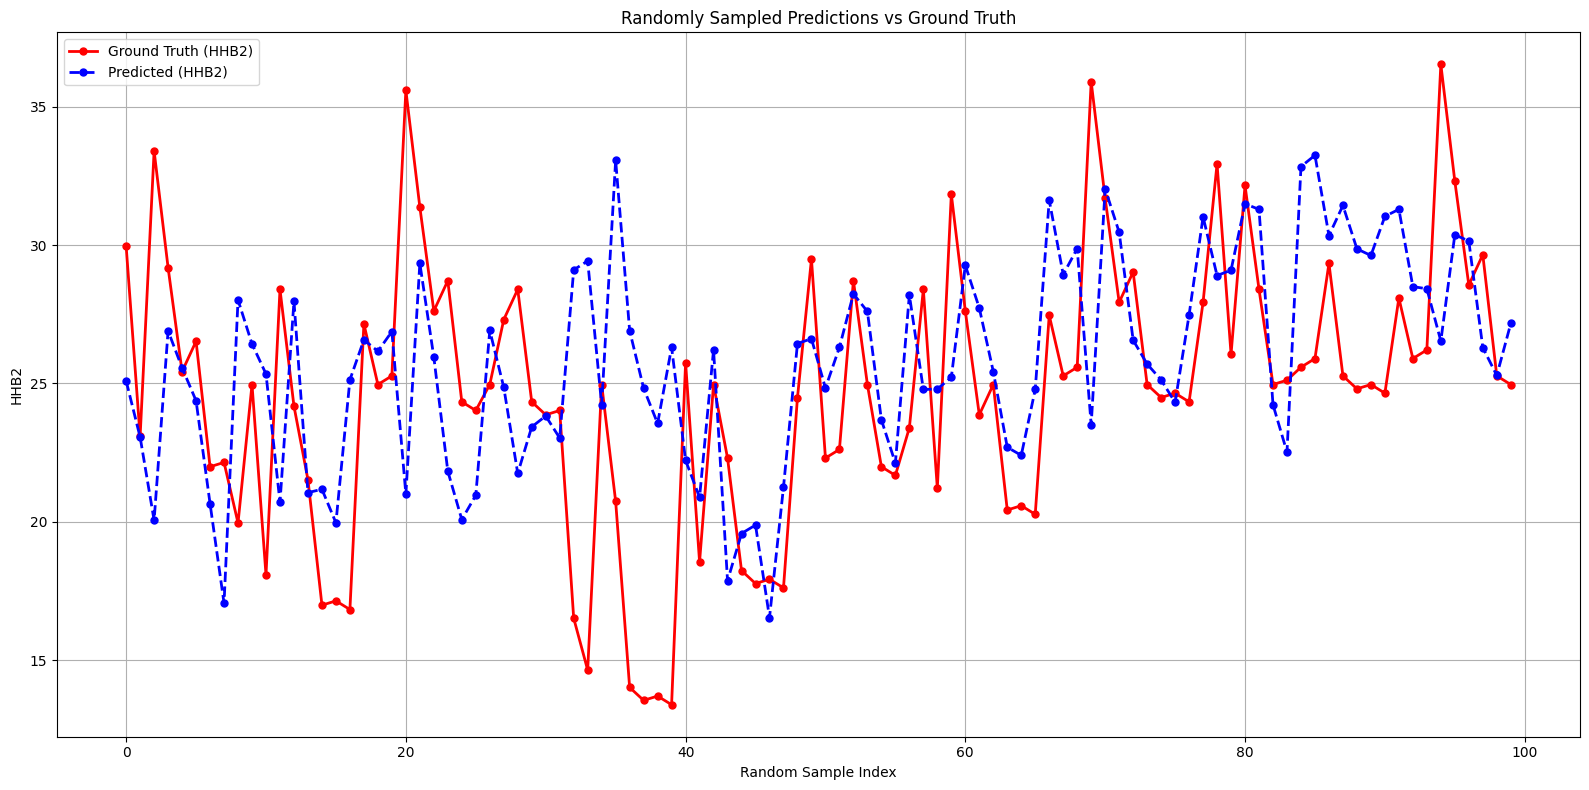

In [39]:
# Randomly select 100 indices
indices = np.random.choice(len(Y_test_diffs), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test_diffs.reshape(-1, 1)).flatten()

# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE (original scale): 31.0362


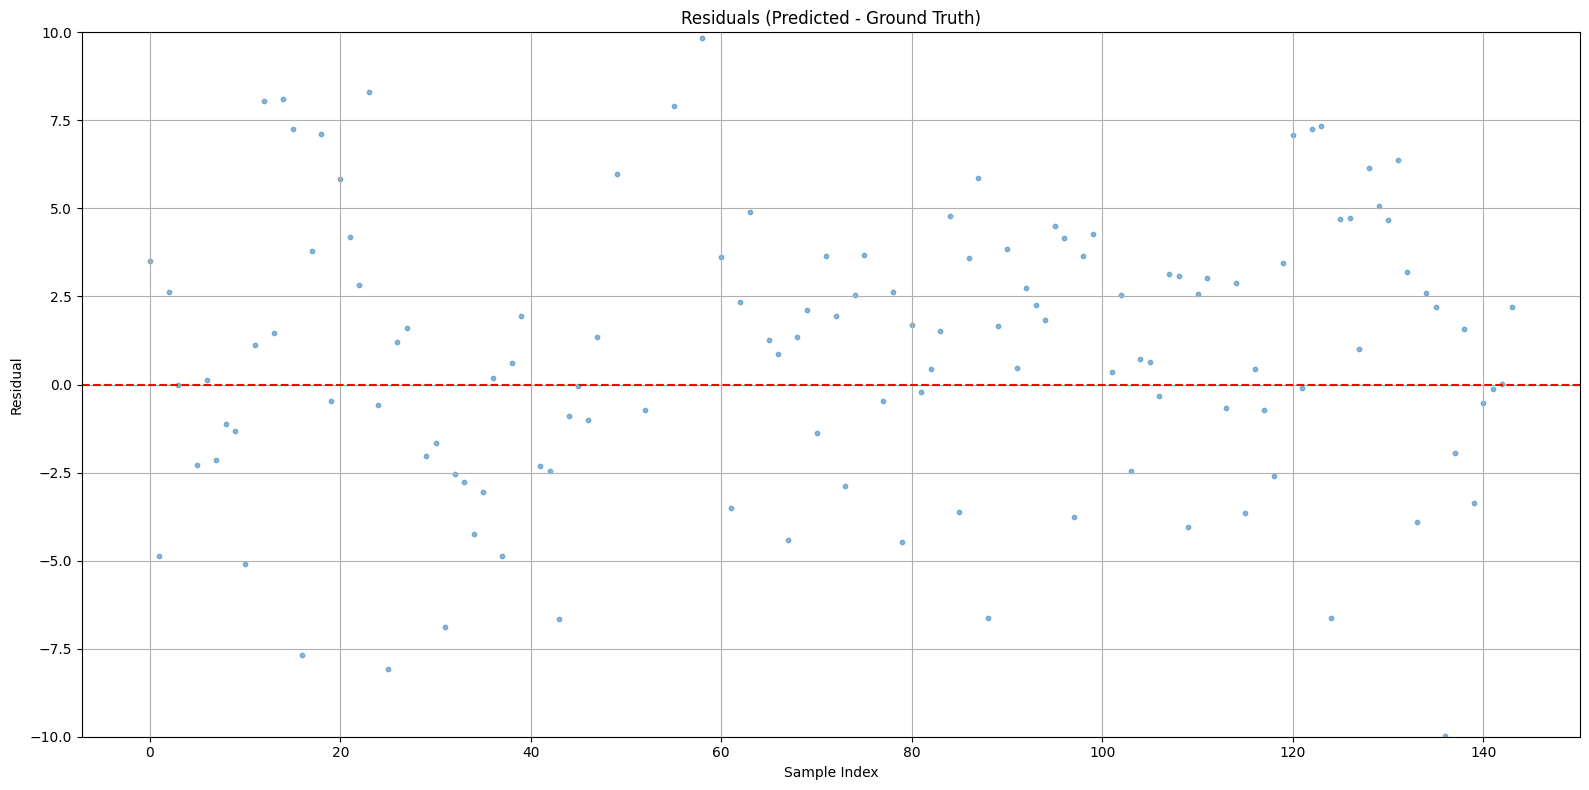

In [40]:
# Inverse-transform predictions and ground truth
y_pred_orig = scaler_y.inverse_transform(y_pred)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(Y_test_diffs)     # shape (n, 1)

# Compute residuals in original scale
residuals = y_pred_orig - y_test_orig

mse_rescaled = mean_squared_error(y_test_orig, y_pred_orig)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.ylim(-10, 10)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

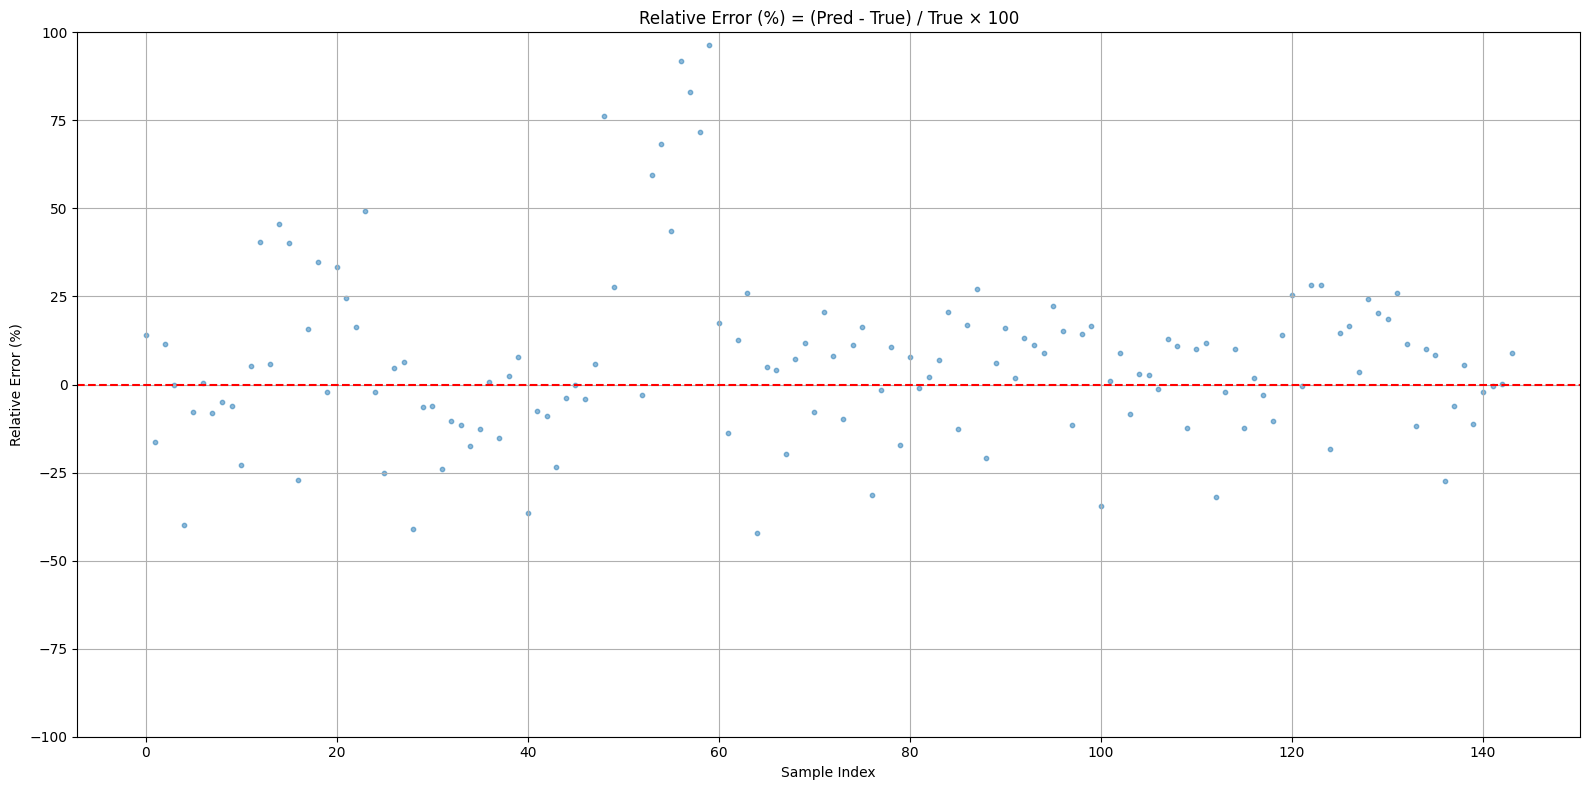

In [42]:
# Inverse-transform predictions and ground truth
y_pred_orig = scaler_y.inverse_transform(y_pred)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(Y_test_diffs)     # shape (n, 1)

# Compute relative error (percentage)
relative_error = ((y_pred_orig - y_test_orig) / y_test_orig) * 100

# Compute mean squared relative error (optional)
#msre = np.mean((relative_error) ** 2)
#print(f"Mean Squared Relative Error (%^2): {msre:.4f}")

# Plot relative error
plt.figure(figsize=(16, 8))
plt.scatter(range(len(relative_error)), relative_error, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Relative Error (%) = (Pred - True) / True × 100")
plt.ylabel("Relative Error (%)")
plt.ylim(-100, 100)  # Adjust range as needed
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()


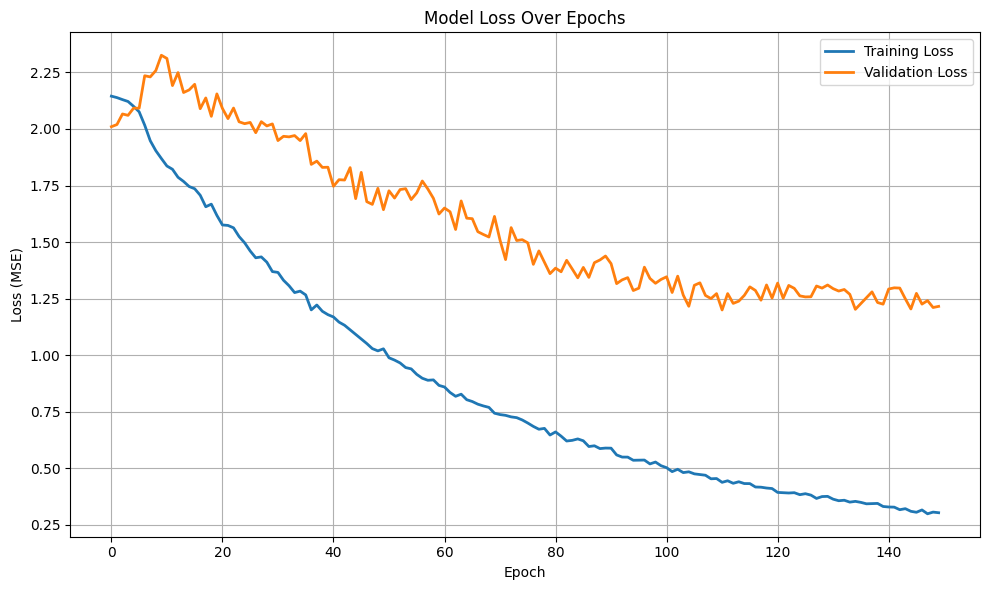

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


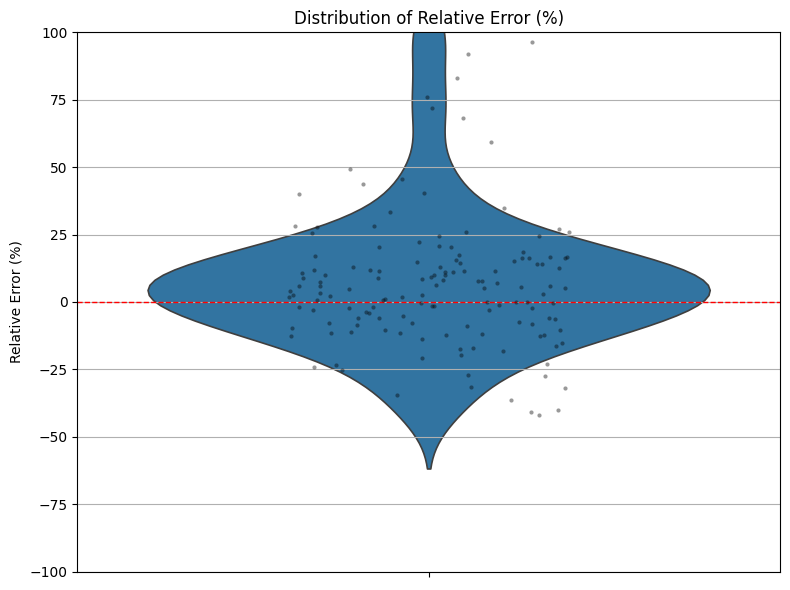

In [44]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare DataFrame for seaborn
df_plot = pd.DataFrame({
    'Relative Error (%)': relative_error.flatten()
})

plt.figure(figsize=(8, 6))
sns.violinplot(data=df_plot, y='Relative Error (%)', inner=None, linewidth=1.2)
sns.stripplot(data=df_plot, y='Relative Error (%)', color='black', alpha=0.4, jitter=0.2, size=3)

plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.ylim(-100, 100)
plt.title('Distribution of Relative Error (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
